In [7]:
from numba import cuda
from numba import jit
import numpy as np


@cuda.jit
def increment_by_one(an_array):
    pos = cuda.grid(1)
    an_array[pos] += 1
    
@jit
def increment_by_one_CPU(an_array):
    an_array += 1
    
    
threadsperblock = 32
    
an_array = np.zeros((threadsperblock*1000,))

blockspergrid = (an_array.size + (threadsperblock - 1)) // threadsperblock
%timeit increment_by_one[blockspergrid, threadsperblock](an_array)

%timeit increment_by_one_CPU(an_array)



2.09 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10 µs ± 47.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### problem setup

I reproduce the function that takes up most of the execution time 
(around 80%) in the Kmeans computation

In [8]:
from numba import cuda
from numba import jit
import numpy as np

def getClosestCentroid( distances ):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    return np.apply_along_axis(np.argmin , 0 , distances )

def getClosestCentroidTransposed( distances ):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    return np.apply_along_axis(np.argmin , 1 , distances )

@cuda.jit
def getClosestCentroidNaiveCuda( distances , m , closestCentroid):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    pos = cuda.grid(1)
    if pos < closestCentroid.size:
        x=1
        minVal=distances[pos,0]
        minInd=0
        while x < m:
            if distances[pos,x]<minVal:
                minVal=distances[pos,x]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    
@cuda.jit
def getClosestCentroidNaiveCudaColumn( distances , m , closestCentroid):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    pos = cuda.grid(1)
    if pos < closestCentroid.size:
        x=1
        minVal=distances[0,pos]
        minInd=0
        while x < m:
            if distances[x,pos]<minVal:
                minVal=distances[x,pos]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    





In [13]:
m=5
n=64000

distances = np.random.random((m,n))
distancesT = distances.T

In [14]:
threadsperblock = 1
blockspergrid = (distancesT.size + (threadsperblock - 1)) // threadsperblock

closestCentroid1 = np.empty((n,))
closestCentroid2 = np.empty((n,))
closestCentroid3 = np.empty((n,))

resCPU = %timeit -n 2 -r 10 -o closestCentroid1 = getClosestCentroidTransposed( distancesT )
resGPU = %timeit -n 2 -r 10 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )
resGPU2 = %timeit -n 2 -r 10 -o getClosestCentroidNaiveCudaColumn[blockspergrid, threadsperblock]( distances , m , closestCentroid3 )

print("GPU speedup",resCPU.best/resGPU.best)

#print(closestCentroid1)
#print(closestCentroid2)
#print(closestCentroid3)

#m=5 , n=64000
# getClosestCentroidTransposed 293 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# getClosestCentroidNaiveCuda 6.53 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#closestCentroid = getClosestCentroid( distances )
#closestCentroid1 = getClosestCentroidTransposed( distancesT )
#getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )
#print(distancesT)
#print(closestCentroid)
#print(closestCentroid1)
#print(closestCentroid2)



289 ms ± 20.7 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)
9.48 ms ± 1.37 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)
9.08 ms ± 958 µs per loop (mean ± std. dev. of 10 runs, 2 loops each)
GPU speedup 37.4472056413567


In [6]:
speedup = np.zeros((11,5))

x = 0
for log2n in np.linspace(10,20,11):
    y=0
    for log2m in np.linspace(1,5,5):
        n = int(2**log2n)
        m = int(2**log2m)
        print(n,m)
        distances = np.random.random((m,n))
        distancesT = distances.T
        closestCentroid1 = np.empty((n,))
        closestCentroid2 = np.empty((n,))

        resCPU = %timeit -n 1 -r 1 -o closestCentroid1 = getClosestCentroidTransposed( distancesT )
        resGPU = %timeit -n 1 -r 1 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )
        speedup[x,y] = resCPU.best/resGPU.best
        y+=1
    x+=1

    

1024 2
9.04 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 4
7.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 8
6.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.83 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 16
6.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 32
6.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.81 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048 2
10.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.67 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048 4
10.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.15 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048 8
10.7 ms ± 0 ns per loop (mean ± st

In [10]:
speedup

array([[  1.49397756,   0.91217512,   1.01064088,   1.48228486,
          1.60013264],
       [  1.91274423,   2.06711501,   2.63138121,   2.28366912,
          2.45100493],
       [  2.58160428,   6.09099048,   4.86899539,   4.00007147,
          4.43941432],
       [  9.25648591,  11.54281345,  11.84130096,   7.84763721,
          7.59229997],
       [ 19.19184247,  15.51183803,  10.06732627,   6.76139387,
          6.18204953],
       [ 33.23433608,  28.01037228,  20.75630721,  13.79268615,
          9.97667601],
       [ 46.05225223,  35.61192669,  28.74260692,  18.50486125,
         10.99888805],
       [ 73.18929888,  55.75419875,  37.25806652,  26.49883478,
         15.82238999],
       [ 47.52676176,  66.13153467,  39.93512269,  25.73787489,
         16.45144545],
       [ 63.24235082,  82.29606573,  46.40446027,  24.10712383,
         19.81282367],
       [136.47309926,  57.0243526 ,  58.10002319,  33.31878424,
         21.37819595]])

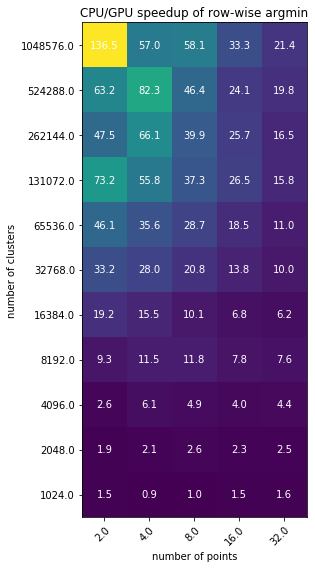

In [15]:
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

N = 2**np.linspace(10,20,11)
M = 2**np.linspace(1,5,5)



fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(speedup)

# We want to show all ticks...
ax.set_xticks(np.arange(len(M)))
ax.set_yticks(np.arange(len(N)))
# ... and label them with the respective list entries
ax.set_xticklabels(M)
ax.set_yticklabels(N)

ax.set_xlabel('number of points')
ax.set_ylabel('number of clusters')

ax.set_xlim(-0.5,len(M)-0.5)
ax.set_ylim(-0.5,len(N)-0.5)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(N)):
    for j in range(len(M)):
        text = ax.text(j, i, '{:.1f}'.format(speedup[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("CPU/GPU speedup of row-wise argmin")
fig.tight_layout()
plt.show()

In [7]:
import Kmeans_serial 
import Kmeans_numba_cuda
from numba import cuda
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

import time

# generating data

## 5 clusters of points 
clusterSizes = [2000,1100,620,400,700 ]
clusterMeans = [ [ 0 , -2 ] ,
				 [ 3 , 3 ] ,
				 [ -1 , 3 ], 
				 [-5, 0] , 
				 [5,-1] ]
clusterSDs = [ [0.5,1] ,
			   [1,0.5] ,
			   [0.5,0.5],
			   [2,1] ,
			   [1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( Kmeans_serial.generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]

Points = np.concatenate( C , axis=1)

realAssignment = np.array(A)



In [8]:

# performing Kmean numba cuda
k=5

InitAssignment = np.random.randint(0,k,sum(clusterSizes))

GPU = %timeit -o kmeanAssignment = Kmeans_numba_cuda.Kmeans( Points , k , maxNbRounds=1000 , assignment=InitAssignment )
CPU = %timeit -o kmeanAssignment = Kmeans_serial.Kmeans( Points , k , maxNbRounds=1000 , assignment=InitAssignment )

print( "n=",sum(clusterSizes) , '\tk=',k )
print( "numbacuda finished in",GPU.best,'seconds' )
print( "serial finished in",CPU.best,'seconds' )
print('speedup best :',CPU.best/GPU.best)
print('speedup average :',CPU.average/GPU.average)

#Kmeans_serial.plotClusters( Points , kmeanAssignment , realAssignment , dimX=0 , dimY=1 )
#plt.show()



110 ms ± 820 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
253 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
n= 4820 	k= 5
numbacuda finished in 0.10813110768795013 seconds
serial finished in 0.2516786828637123 seconds
speedup best : 2.3275326429654135
speedup average : 2.3034371116814913
